In [1]:
import pandas as pd

# Carregar o dataset
df = pd.read_csv('winequality-white.csv', sep=';')

# Verificando as primeiras linhas do DataFrame
print(df.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8        6  
1      9.5        6  
2     10.1        6 

In [2]:
# Removendo a coluna 'quality'
df = df.drop(columns=['quality'])


In [3]:
from sklearn.model_selection import train_test_split

# Dividindo os dados
train_df, test_df = train_test_split(df, test_size=0.25, random_state=42)

In [4]:
def normalize_data(train, test):
    train_mean = train.mean()
    train_std = train.std()
    
    train = (train - train_mean) / train_std
    test = (test - train_mean) / train_std
    
    return train, test

train_df, test_df = normalize_data(train_df, test_df)


In [5]:
y_train = train_df.pop('alcohol')
y_test = test_df.pop('alcohol')


In [6]:
import numpy as np

def k_folds(X, y, k=5):
    fold_size = len(X) // k
    folds = []
    
    for i in range(k):
        X_fold = X[i*fold_size:(i+1)*fold_size]
        y_fold = y[i*fold_size:(i+1)*fold_size]
        folds.append((X_fold, y_fold))
        
    return folds

# Testando a função
folds_5 = k_folds(train_df, y_train, k=5)

In [7]:
class OLSRegression:
    def __init__(self):
        self.coefficients = []
        
    def fit(self, X, y):
        X = np.c_[np.ones(X.shape[0]), X]  # Adicionando uma coluna de 1s para o intercepto
        self.coefficients = np.linalg.inv(X.T @ X) @ X.T @ y
        
    def predict(self, X):
        X = np.c_[np.ones(X.shape[0]), X]
        return X @ self.coefficients


In [8]:
from sklearn.metrics import mean_squared_error, r2_score

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return rmse, r2


In [9]:
ols = OLSRegression()

for i, (X_fold, y_fold) in enumerate(folds_5):
    ols.fit(X_fold, y_fold)
    predictions = ols.predict(X_fold)
    
    rmse, r2 = calculate_metrics(y_fold, predictions)
    print(f"Fold {i+1} - RMSE: {rmse}, R2: {r2}")


Fold 1 - RMSE: 0.28447910607824745, R2: 0.9195854953588534
Fold 2 - RMSE: 0.29935539832417757, R2: 0.9082008773181525
Fold 3 - RMSE: 0.5090996379533564, R2: 0.7428989445321668
Fold 4 - RMSE: 0.32282083331401007, R2: 0.8974207103263075
Fold 5 - RMSE: 0.3133540302665159, R2: 0.9010521300838681


In [10]:
# Fazendo predições no conjunto de teste
test_predictions = ols.predict(test_df)
test_rmse, test_r2 = calculate_metrics(y_test, test_predictions)

print(f"Test RMSE: {test_rmse}, Test R2: {test_r2}")


Test RMSE: 0.2997078092365056, Test R2: 0.9102900082234456


In [13]:
def train_and_evaluate(folds):
    rmses = []
    r2s = []
    ols = OLSRegression()

    for i, (X_fold, y_fold) in enumerate(folds):
        ols.fit(X_fold, y_fold)
        predictions = ols.predict(X_fold)

        rmse, r2 = calculate_metrics(y_fold, predictions)
        rmses.append(rmse)
        r2s.append(r2)
        print(f"Fold {i+1} - RMSE: {rmse}, R2: {r2}")
    
    return rmses, r2s

rmses_5, r2s_5 = train_and_evaluate(folds_5)


Fold 1 - RMSE: 0.28447910607824745, R2: 0.9195854953588534
Fold 2 - RMSE: 0.29935539832417757, R2: 0.9082008773181525
Fold 3 - RMSE: 0.5090996379533564, R2: 0.7428989445321668
Fold 4 - RMSE: 0.32282083331401007, R2: 0.8974207103263075
Fold 5 - RMSE: 0.3133540302665159, R2: 0.9010521300838681


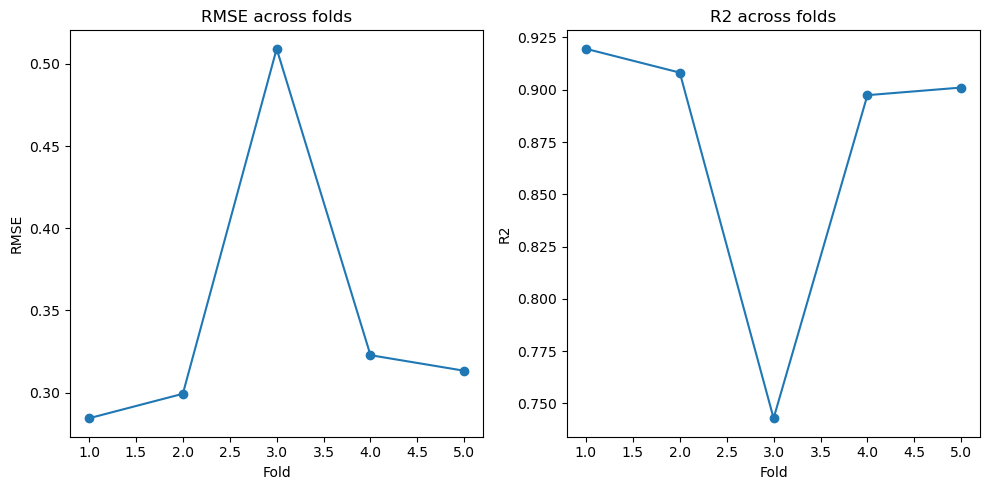

In [14]:
def plot_results(rmses, r2s):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(rmses)+1), rmses, marker='o')
    plt.title('RMSE across folds')
    plt.xlabel('Fold')
    plt.ylabel('RMSE')

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(r2s)+1), r2s, marker='o')
    plt.title('R2 across folds')
    plt.xlabel('Fold')
    plt.ylabel('R2')

    plt.tight_layout()
    plt.show()

# Chamar a função de plotagem com os resultados
plot_results(rmses_5, r2s_5)


In [15]:
folds_5 = k_folds(train_df, y_train, k=5)
folds_10 = k_folds(train_df, y_train, k=10)

# Treinar e avaliar usando 5 folds
print("Resultados com 5 Folds:")
rmses_5, r2s_5 = train_and_evaluate(folds_5)

# Treinar e avaliar usando 10 folds
print("\nResultados com 10 Folds:")
rmses_10, r2s_10 = train_and_evaluate(folds_10)


Resultados com 5 Folds:
Fold 1 - RMSE: 0.28447910607824745, R2: 0.9195854953588534
Fold 2 - RMSE: 0.29935539832417757, R2: 0.9082008773181525
Fold 3 - RMSE: 0.5090996379533564, R2: 0.7428989445321668
Fold 4 - RMSE: 0.32282083331401007, R2: 0.8974207103263075
Fold 5 - RMSE: 0.3133540302665159, R2: 0.9010521300838681

Resultados com 10 Folds:
Fold 1 - RMSE: 0.28711022468426656, R2: 0.9171404798409842
Fold 2 - RMSE: 0.27347235237434375, R2: 0.9265257571023892
Fold 3 - RMSE: 0.2855230296805126, R2: 0.9243505428564556
Fold 4 - RMSE: 0.30653217117374315, R2: 0.8920964531699539
Fold 5 - RMSE: 0.2841337151798272, R2: 0.9219197306863816
Fold 6 - RMSE: 0.5839981918617407, R2: 0.6514428957878353
Fold 7 - RMSE: 0.33117810770290296, R2: 0.8910420106112836
Fold 8 - RMSE: 0.29662494334136646, R2: 0.914037734629301
Fold 9 - RMSE: 0.29431456854379134, R2: 0.9155979638135587
Fold 10 - RMSE: 0.3247025903481345, R2: 0.8881882277404891


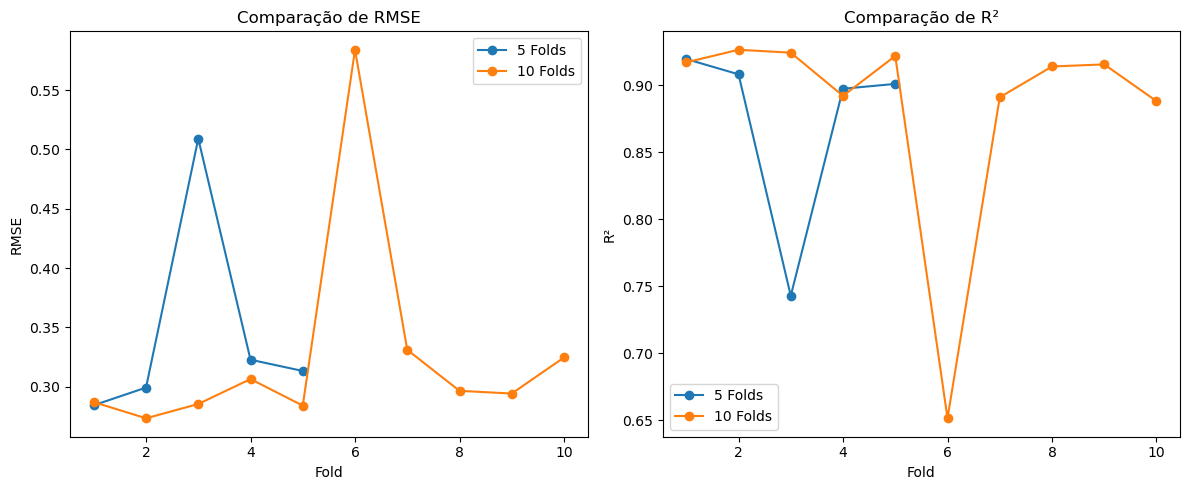

In [16]:
def plot_comparison(rmses_5, r2s_5, rmses_10, r2s_10):
    plt.figure(figsize=(12, 5))
    
    # RMSE
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(rmses_5)+1), rmses_5, marker='o', label='5 Folds')
    plt.plot(range(1, len(rmses_10)+1), rmses_10, marker='o', label='10 Folds')
    plt.title('Comparação de RMSE')
    plt.xlabel('Fold')
    plt.ylabel('RMSE')
    plt.legend()
    
    # R²
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(r2s_5)+1), r2s_5, marker='o', label='5 Folds')
    plt.plot(range(1, len(r2s_10)+1), r2s_10, marker='o', label='10 Folds')
    plt.title('Comparação de R²')
    plt.xlabel('Fold')
    plt.ylabel('R²')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Chamar a função de plotagem com os resultados
plot_comparison(rmses_5, r2s_5, rmses_10, r2s_10)



RMSE no conjunto de teste: 0.3077167813038683
R² no conjunto de teste: 0.9054313780025234


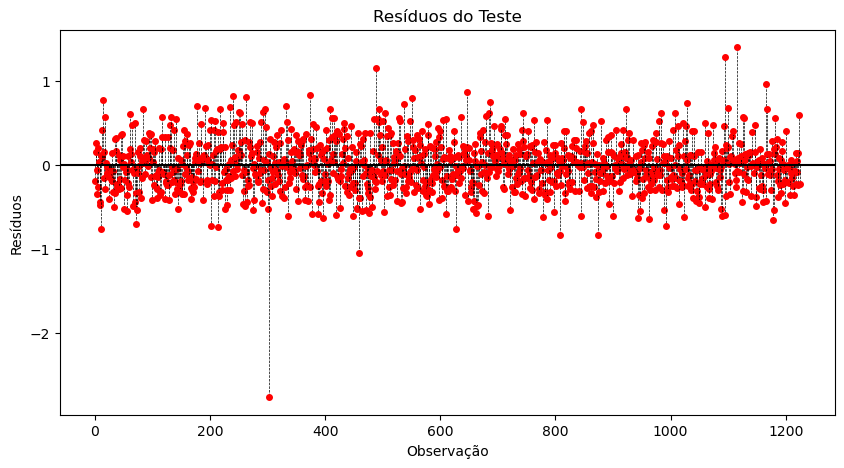

In [17]:
def predict_and_evaluate(test_data, y_test, model):
    # Fazendo previsões
    y_pred = model.predict(test_data)
    
    # Calculando e imprimindo as métricas
    rmse, r2 = calculate_metrics(y_test, y_pred)
    print(f"RMSE no conjunto de teste: {rmse}")
    print(f"R² no conjunto de teste: {r2}")
    
    # Gráfico de Resíduos
    residuals = y_test - y_pred
    fig, ax = plt.subplots(figsize=(10, 5))
    for i, residual in enumerate(residuals):
        ax.plot([i, i], [0, residual], color='black', linestyle='--', linewidth=0.5)
        ax.plot(i, residual, marker='o', markersize=4, color='red')
    ax.axhline(y=0, color='black', linestyle='-')
    ax.set_xlabel('Observação')
    ax.set_ylabel('Resíduos')
    ax.set_title('Resíduos do Teste')
    plt.show()

# Instanciando e treinando o modelo com todos os dados de treino
ols_model = OLSRegression()
ols_model.fit(train_df, y_train)

# Prevendo e avaliando o modelo no conjunto de teste
predict_and_evaluate(test_df, y_test, ols_model)
